In [ ]:
# ====================================
# 1. Imports and Setup
# ====================================

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display


sns.set_theme()
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


In [ ]:
# === Figure helper ===
from pathlib import Path
FIGDIR = Path("/content/figures"); FIGDIR.mkdir(exist_ok=True)

def finalize(ax, title, xlabel, ylabel, fname):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(FIGDIR/fname, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# ====================================
# 2. Load Dataset
# ====================================

df = pd.read_csv("Original Dataset.csv")
print(df.shape)
df.head(3)

(251079, 15)


,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,"160,500.00",2.0 V6 TB
1,1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),"190,000.00","Q4 Allrad, 3.2L GTA"
2,2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),"129,000.00",ALFA ROME 916


In [ ]:
# ====================================
# 3. Data Cleaning & Preprocessing
# ====================================

# Normalize columns
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Rename common aliases
aliases = {"price_in_euro":["price","price_eur"], "power_ps":["hp","horsepower","kw"],
           "mileage_in_km":["mileage","km"], "year":["year_of_production","production_year"]}
for canon, opts in aliases.items():
    for o in opts:
        if o in df: df.rename(columns={o:canon}, inplace=True)

# Convert kW → PS if needed
if "kw" in df: df["power_ps"] = df["kw"] * 1.35962

# Type conversions
for c in ["price_in_euro","power_ps","mileage_in_km","year"]:
    if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")

# Outlier filters
df = df[df["price_in_euro"].between(500,200000)]
df = df[df["power_ps"].between(30,1000)]
df = df[df["mileage_in_km"] < 500000]
df = df[df["year"].between(1995,2024)]

# Drop NAs & duplicates
df = df.dropna(subset=["price_in_euro","power_ps","mileage_in_km","year"])
df = df.drop_duplicates()
print("Clean shape:", df.shape)


Clean shape: (248853, 15)


In [ ]:
# ====================================
# 4. Feature Engineering
# ====================================

CURR = 2023
df["car_age"] = CURR - df["year"]
df["log_price"] = np.log1p(df["price_in_euro"])
df["price_per_hp"] = df["price_in_euro"]/df["power_ps"]
df["price_per_km"] = df["price_in_euro"]/(1+df["mileage_in_km"])


Price↔HP: 0.7036474793664511
Price↔Mileage: -0.4272260918582091


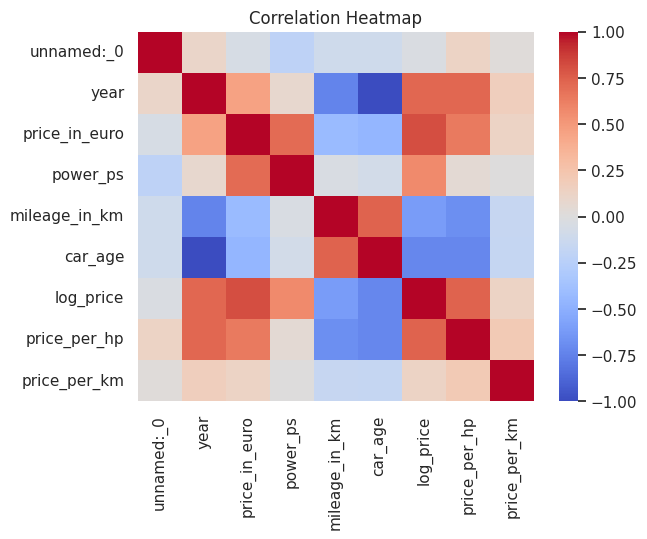

In [ ]:
# ====================================
# 5. Correlation Analysis
# ====================================
print("Price↔HP:", df["price_in_euro"].corr(df["power_ps"]))
print("Price↔Mileage:", df["price_in_euro"].corr(df["mileage_in_km"]))

sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# === Descriptive Statistics ====
df[["mileage_in_km","price_in_euro","power_ps"]].describe()


,mileage_in_km,price_in_euro,power_ps
count,"248,853.00","248,853.00","248,853.00"
mean,"85,343.23","24,232.78",168.99
std,"75,116.50","20,823.65",91.11
min,0.00,500.00,34.00
25%,"25,350.00","11,990.00",110.00
50%,"68,000.00","19,800.00",150.00
75%,"127,000.00","29,850.00",190.00
max,"499,990.00","199,999.00",956.00


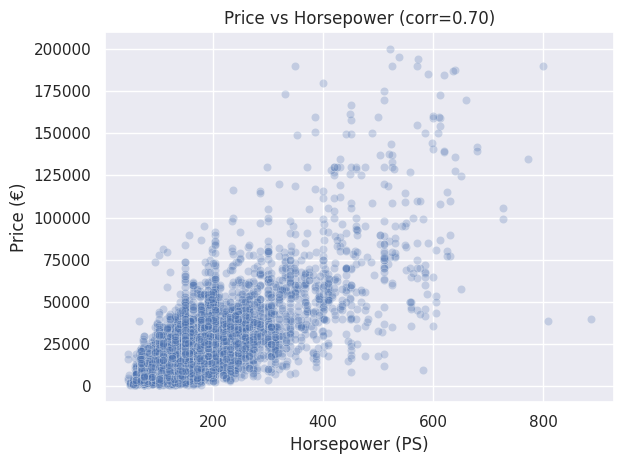

,brand,model,power_ps,price_in_euro
80567,hyundai,Hyundai IONIQ,34.00,"21,990.00"
213802,volkswagen,Volkswagen Käfer,34.00,"4,900.00"


,brand,model,power_ps,price_in_euro
122285,mercedes-benz,Mercedes-Benz E 63 AMG,956.00,"28,940.00"


77.7% of cars have less than 200 HP


In [ ]:
# === Price vs Horsepower ===
sample_hp = df.sample(min(len(df), 8000), random_state=42)
ax = sns.scatterplot(data=sample_hp, x="power_ps", y="price_in_euro", alpha=0.25)
finalize(ax,
         f"Price vs Horsepower (corr={df['price_in_euro'].corr(df['power_ps']):.2f})",
         "Horsepower (PS)", "Price (€)", "price_vs_hp.png")


# Lowest horsepower cars
lowest_hp = df[df["power_ps"] == df["power_ps"].min()][["brand","model","power_ps","price_in_euro"]]
display(lowest_hp)

# Highest horsepower cars
highest_hp = df[df["power_ps"] == df["power_ps"].max()][["brand","model","power_ps","price_in_euro"]]
display(highest_hp)

perc_under_200 = (df[df["power_ps"] < 200].shape[0] / df.shape[0]) * 100
print(f"{perc_under_200:.1f}% of cars have less than 200 HP")



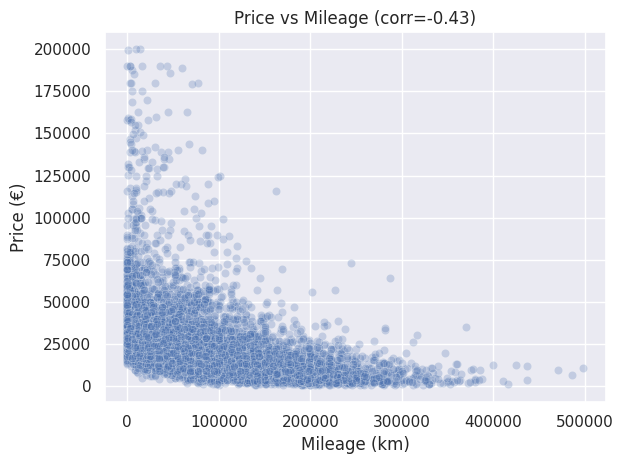

In [ ]:
# === Price vs Mileage ===
sample_mi = df.sample(min(len(df), 8000), random_state=43)
ax = sns.scatterplot(data=sample_mi, x="mileage_in_km", y="price_in_euro", alpha=0.25)
finalize(ax,
         f"Price vs Mileage (corr={df['price_in_euro'].corr(df['mileage_in_km']):.2f})",
         "Mileage (km)", "Price (€)", "price_vs_mileage.png")


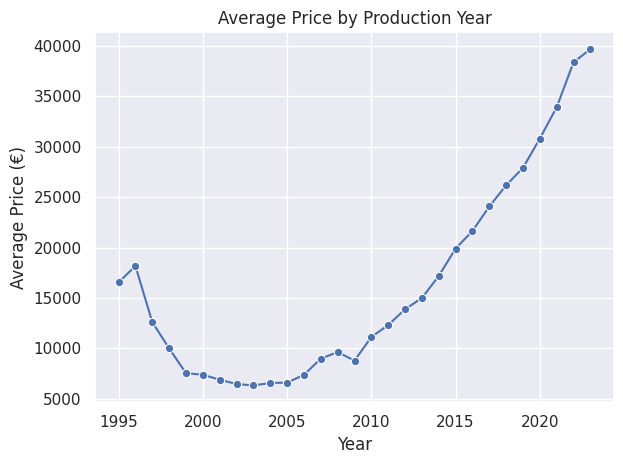

In [ ]:
# ====================================
# 6. Trend Analysis
# ====================================

# Average Price by Production Year (pre-aggregated = version-proof)
avg_by_year = df.groupby("year", as_index=False)["price_in_euro"].mean().sort_values("year")
ax = sns.lineplot(x="year", y="price_in_euro", data=avg_by_year, marker="o")
finalize(ax, "Average Price by Production Year", "Year", "Average Price (€)", "avg_price_by_year.png")


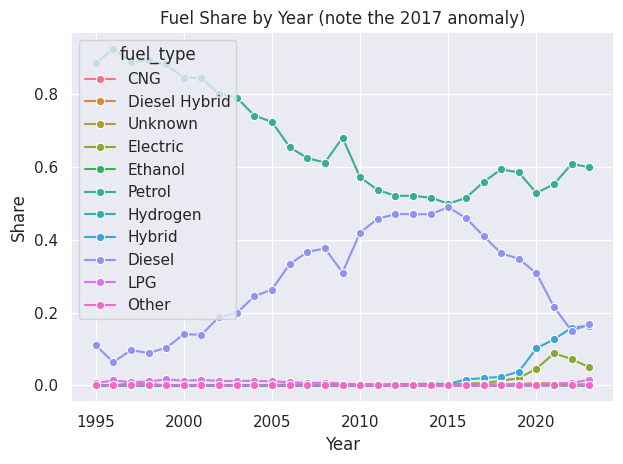

,year,fuel_type,share
283,"2,017.00",Petrol,0.56
51,"2,017.00",Diesel,0.41
167,"2,017.00",Hybrid,0.02
109,"2,017.00",Electric,0.01
225,"2,017.00",LPG,0.00
22,"2,017.00",CNG,0.00
196,"2,017.00",Hydrogen,0.00
80,"2,017.00",Diesel Hybrid,0.00
254,"2,017.00",Other,0.00
312,"2,017.00",Unknown,0.00


In [ ]:
# === Fuel Share by Year (pivot-table method) ===
need = {"year","fuel_type"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns for fuel analysis: {missing}")

fuel_counts = pd.pivot_table(
    df, index="year", columns="fuel_type",
    values="price_in_euro", aggfunc="size", fill_value=0
)
fuel_share = fuel_counts.div(fuel_counts.sum(axis=1), axis=0)
fuel_year = fuel_share.reset_index().melt(
    id_vars="year", var_name="fuel_type", value_name="share"
)

ax = sns.lineplot(data=fuel_year.sort_values("year"),
                  x="year", y="share", hue="fuel_type", marker="o")
finalize(ax,
         "Fuel Share by Year (note the 2017 anomaly)",
         "Year", "Share", "fuel_share_by_year.png")

# 2017 snapshot (so you can quote numbers)
fuel_year_2017 = fuel_year.query("year == 2017").sort_values("share", ascending=False)
display(fuel_year_2017)




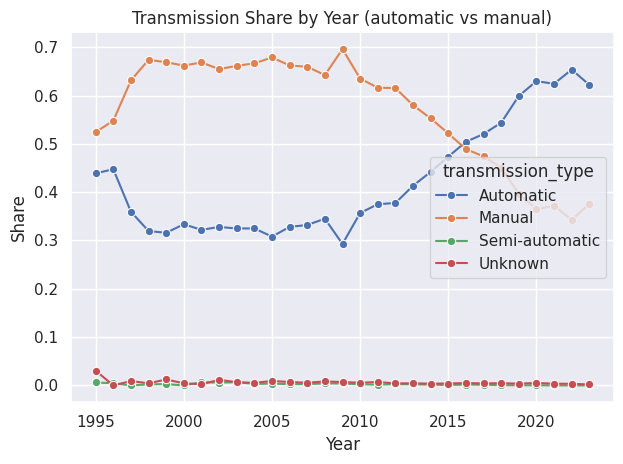

transmission_type
Automatic         116661
Manual            110314
Unknown             1038
Semi-automatic       292
Name: count, dtype: int64


,count
transmission_type,
Automatic,51.10
Manual,48.32
Unknown,0.45
Semi-automatic,0.13


In [ ]:
# === Transmission Share by Year (pivot-table method) ===
need = {"year","transmission_type"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns for transmission analysis: {missing}")

gear_counts = pd.pivot_table(
    df, index="year", columns="transmission_type",
    values="price_in_euro", aggfunc="size", fill_value=0
)
gear_share = gear_counts.div(gear_counts.sum(axis=1), axis=0)
gear_year = gear_share.reset_index().melt(
    id_vars="year", var_name="transmission_type", value_name="share"
)

ax = sns.lineplot(data=gear_year.sort_values("year"),
                  x="year", y="share", hue="transmission_type", marker="o")
finalize(ax,
         "Transmission Share by Year (automatic vs manual)",
         "Year", "Share", "transmission_share_by_year.png")

# Count transmission types
transmission_counts = df["transmission_type"].value_counts(dropna=False)
print(transmission_counts)

# If you want percentage too:
(transmission_counts / len(df) * 100).round(2)

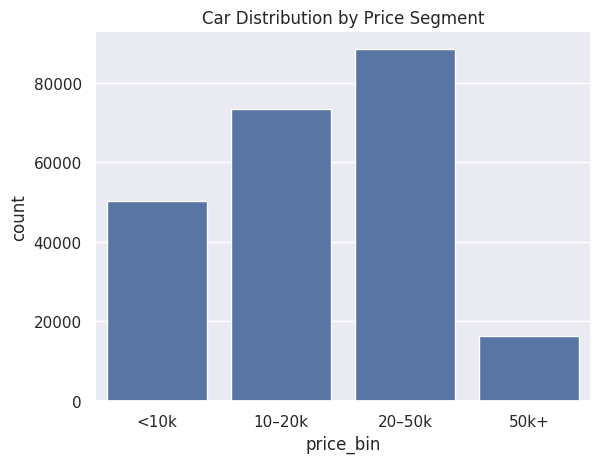

In [ ]:
#  == Price segment distribution ==

bins = [0,10000,20000,50000,np.inf]
labels = ["<10k","10–20k","20–50k","50k+"]
df["price_bin"] = pd.cut(df["price_in_euro"], bins=bins, labels=labels)

sns.countplot(x="price_bin", data=df, order=labels)
plt.title("Car Distribution by Price Segment")
plt.show()





Saved: /content/figures/fuel_types_by_price_band_donut.png


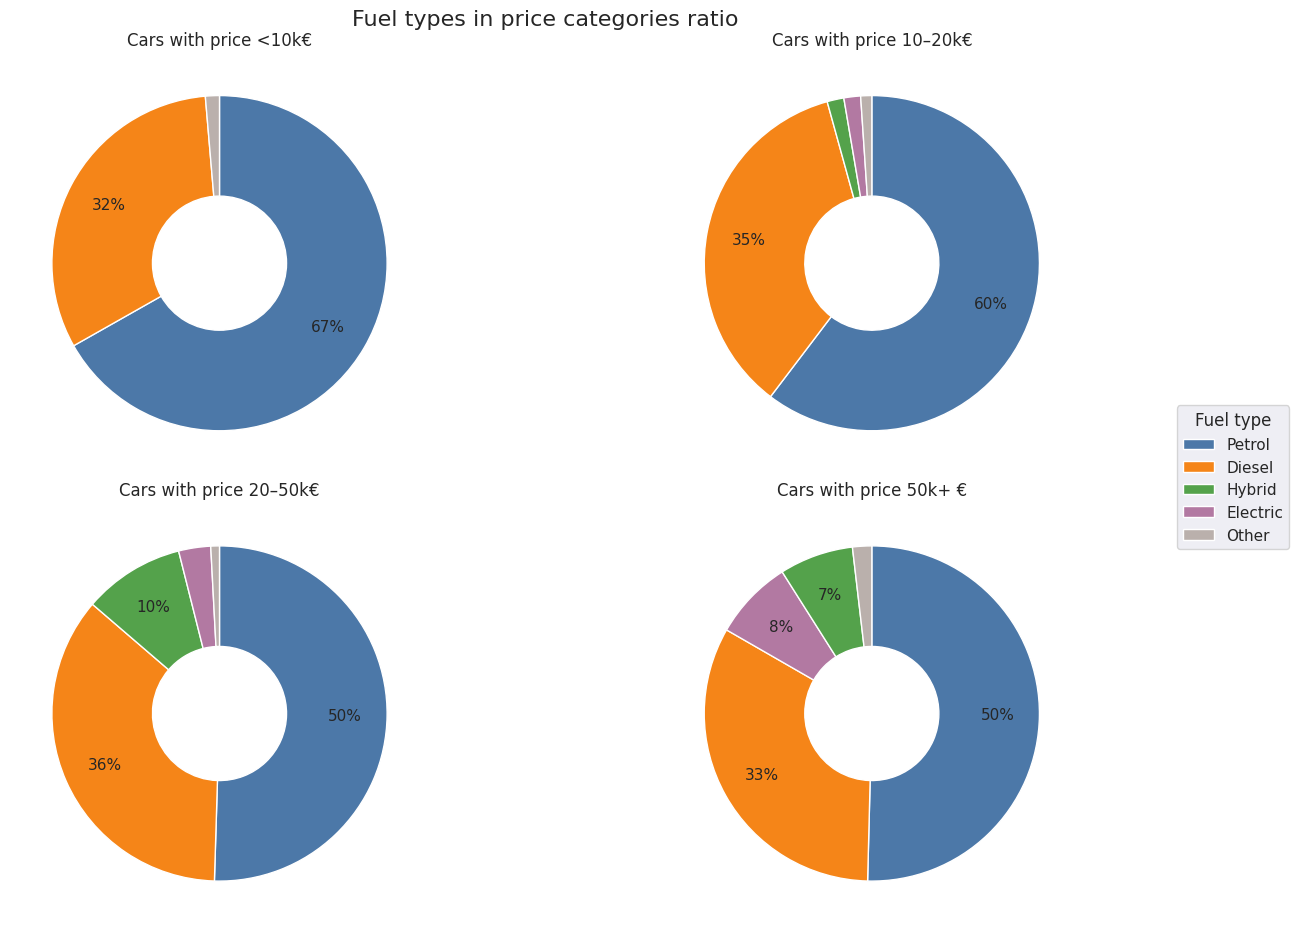

In [59]:
# == FUEL TYPES IN PRICE CATEGORY RATIO ==

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Order categories in legend (only those that appear will be shown)
legend_order = ["Petrol","Diesel","Hybrid","Electric","LPG","CNG","Diesel Hybrid","Hydrogen","Other","Unknown"]

def color_for(name):
    return {
        "Petrol":"#4C78A8","Gasoline":"#4C78A8",
        "Diesel":"#F58518","Hybrid":"#54A24B","Electric":"#B279A2",
        "LPG":"#E45756","CNG":"#72B7B2","Diesel Hybrid":"#FF9DA6",
        "Hydrogen":"#9C755F","Other":"#BAB0AC","Unknown":"#A0A0A0",
    }.get(name, "#CCCCCC")

fig, axes = plt.subplots(2, 2, figsize=(13, 9), constrained_layout=True)
axes = axes.ravel()
titles = {
    "<10k":"Cars with price <10k€",
    "10–20k":"Cars with price 10–20k€",
    "20–50k":"Cars with price 20–50k€",
    "50k+":"Cars with price 50k+ €",
}

# show % only for slices >= 4%
fmt = lambda p: f"{p:.0f}%" if p >= 4 else ""

for ax, band in zip(axes, ["<10k","10–20k","20–50k","50k+"]):
    part = fuel_clean[fuel_clean["price_bin"] == band]
    sizes = part["percent"].to_numpy()
    labels = part["fuel_type"].tolist()
    colors = [color_for(x) for x in labels]

    ax.pie(
        sizes,
        labels=None,                    # no names on wedges -> much cleaner
        autopct=fmt,                    # show only bigger %s
        startangle=90,
        counterclock=False,
        pctdistance=0.75,
        textprops={"fontsize":11},
        wedgeprops={"width":0.6, "edgecolor":"white", "linewidth":1},  # donut + separators
        colors=colors,
    )
    ax.set_title(titles[band], fontsize=12)

# --- one global legend on the right (only categories that actually appear) ---
present = [c for c in legend_order
           if c in fuel_clean["fuel_type"].unique()]
handles = [Patch(facecolor=color_for(c), edgecolor="white", label=c) for c in present]
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.98, 0.5), title="Fuel type")

fig.suptitle("Fuel types in price categories ratio", fontsize=16, y=1.02)

# save (uses your FIGDIR if defined)
try:
    out = FIGDIR / "fuel_types_by_price_band_donut.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)
except Exception:
    pass

plt.show()


In [60]:
# ====================================
# 7. Brand and Model Statistics
# ====================================

# Top 10 brands by number of listings
topN = 10
brand_table = (df.groupby("brand", as_index=False)
                 .agg(avg_price=("price_in_euro","mean"),
                      cars=("price_in_euro","size"),
                      avg_mileage=("mileage_in_km","mean"))
                 .sort_values("cars", ascending=False)
                 .head(topN))

# Pretty formatting for display/export
brand_table_formatted = brand_table.copy()
brand_table_formatted["avg_price"]  = brand_table_formatted["avg_price"].round(2)
brand_table_formatted["avg_mileage"]= brand_table_formatted["avg_mileage"].round(2)
brand_table_formatted.rename(columns={
    "brand":"Brand",
    "avg_price":"Average price, €",
    "cars":"Cars represented",
    "avg_mileage":"Average mileage"
}, inplace=True)

brand_table_formatted


,Brand,"Average price, €",Cars represented,Average mileage
45,volkswagen,"18,873.61",33199,"110,819.09"
29,mercedes-benz,"28,785.70",26945,"119,073.94"
2,audi,"28,255.81",21116,"108,099.32"
33,opel,"14,673.77",20332,"83,002.82"
4,bmw,"24,601.60",19744,"126,023.34"
15,ford,"20,376.81",18738,"80,815.04"
41,skoda,"22,295.70",14013,"67,295.84"
40,seat,"21,925.23",11935,"50,945.61"
37,renault,"17,340.93",8646,"66,547.94"
44,toyota,"24,978.24",8187,"43,440.60"


In [75]:
#  Generate Top 10 Brand–Model Combinations
#  (removing duplicated brand names from model column)

import re

def strip_brand_from_model(brand, model):
    """Remove leading brand from the model string (case- and separator-insensitive)."""
    if not isinstance(brand, str) or not isinstance(model, str):
        return model

    # If the model doesn't start with the brand (ignoring punctuation), keep as-is
    brand_norm = re.sub(r'[\W_]+', '', brand.lower())
    model_norm = re.sub(r'[\W_]+', '', model.lower())
    if not model_norm.startswith(brand_norm):
        return model.strip()

    # Build a regex that matches the brand tokens with any separators between them
    tokens = [t for t in re.split(r'[\W_]+', brand) if t]
    pattern = r'^\s*' + r'[\s\-\._/]*'.join(map(re.escape, tokens)) + r'[\s\-\._/]*'
    cleaned = re.sub(pattern, '', model, flags=re.IGNORECASE).strip()
    return cleaned or model.strip()  # fallback if everything gets removed


In [76]:
# Apply cleaner
df["brand"] = df["brand"].astype(str).str.strip()
df["model"] = df["model"].astype(str).str.strip()
df["model_clean"] = [strip_brand_from_model(b, m) for b, m in zip(df["brand"], df["model"])]

In [77]:
top_model_table = (df.groupby(["brand","model_clean"], as_index=False)
                     .agg(avg_price=("price_in_euro","mean"),
                          cars=("price_in_euro","size"),
                          avg_mileage=("mileage_in_km","mean"))
                     .sort_values("cars", ascending=False)
                     .head(10))

# Pretty formatting
top_model_table_formatted = top_model_table.rename(columns={
    "brand": "Brand",
    "model_clean": "Model",
    "avg_price": "Average price, €",
    "cars": "Cars represented",
    "avg_mileage": "Average mileage",
}).copy()

top_model_table_formatted["Average price, €"] = top_model_table_formatted["Average price, €"].round(2)
top_model_table_formatted["Average mileage"]  = top_model_table_formatted["Average mileage"].round(2)

display(top_model_table_formatted)


,Brand,Model,"Average price, €",Cars represented,Average mileage
1195,volkswagen,Golf,"13,843.98",7579,"117,616.14"
963,opel,Astra,"12,584.58",4358,"99,991.19"
969,opel,Corsa,"11,490.24",4272,"71,208.39"
1105,seat,Leon,"21,068.68",4115,"62,923.97"
370,ford,Focus,"15,702.50",3861,"90,061.19"
1118,skoda,Octavia,"21,575.39",3815,"90,188.80"
36,audi,A3,"18,393.43",3564,"104,592.42"
37,audi,A4,"18,722.91",3388,"137,898.75"
1219,volkswagen,Polo,"10,061.31",3131,"106,249.85"
40,audi,A6,"25,138.52",2877,"147,814.87"


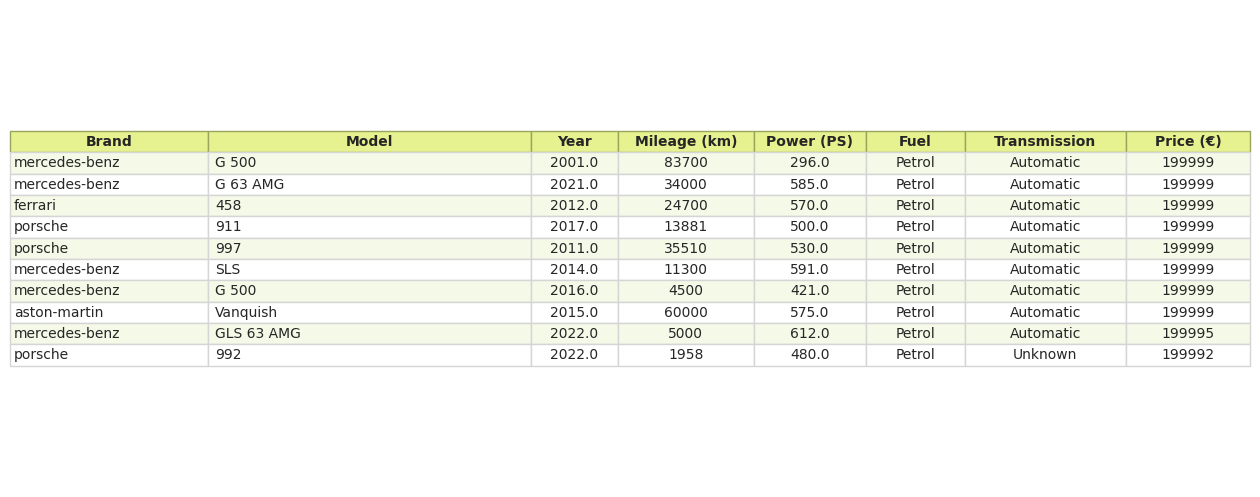

Saved: /content/figures/top10_expensive_listings_pretty.png


In [88]:
# ===========================================
# Top 10 Most Expensive Listings (pretty table)
# - Wider figure + fixed column widths
# - Left-aligned Brand/Model
# - Optional model_clean used to avoid brand duplication
# - Long model names shortened with ellipsis
# ===========================================
import textwrap
import matplotlib.pyplot as plt

# Prefer cleaned model if present
model_col = "model_clean" if "model_clean" in df.columns else "model"

cols = ["brand", model_col, "year", "mileage_in_km", "power_ps",
        "fuel_type", "transmission_type", "price_in_euro"]

top_cars = (df[cols]
            .sort_values("price_in_euro", ascending=False)
            .head(10)
            .copy())

# Format for display
top_cars_fmt = top_cars.rename(columns={
    "brand": "Brand",
    model_col: "Model",
    "year": "Year",
    "mileage_in_km": "Mileage (km)",
    "power_ps": "Power (PS)",
    "fuel_type": "Fuel",
    "transmission_type": "Transmission",
    "price_in_euro": "Price (€)",
})

# numeric formatting
top_cars_fmt["Price (€)"] = top_cars_fmt["Price (€)"].round(0).astype(int)
top_cars_fmt["Mileage (km)"] = top_cars_fmt["Mileage (km)"].round(0).astype(int)

# shorten long model names for better fit (adjust width as needed)
def short(s, width=26):
    s = str(s)
    # try a soft wrap first; if still long, shorten with ellipsis
    if len(s) <= width:
        return s
    return textwrap.shorten(s, width=width, placeholder="…")

top_cars_fmt["Model"] = top_cars_fmt["Model"].map(lambda x: short(x, 28))

# ---- draw table ----
fig, ax = plt.subplots(figsize=(16, 6.2))  # wider canvas to prevent crowding
ax.axis("off")

# zebra striping
rows = len(top_cars_fmt)
row_colors = ["#F5F9E7" if i % 2 == 0 else "white" for i in range(rows)]

# set fixed column widths (sum ~ 1.0). Give Brand/Model more room.
colWidths = [0.16, 0.26, 0.07, 0.11, 0.09, 0.08, 0.13, 0.10]

tbl = ax.table(
    cellText=top_cars_fmt.values,
    colLabels=top_cars_fmt.columns,
    cellLoc="center", colLoc="center",
    colWidths=colWidths,
    loc="center"
)

# header style
for j in range(len(top_cars_fmt.columns)):
    h = tbl[0, j]
    h.set_facecolor("#E6F28F")
    h.set_text_props(weight="bold")
    h.set_edgecolor("#9AA45C")

# body cells: zebra + borders + left-align 0:'Brand' and 1:'Model'
for i in range(rows):
    for j in range(len(top_cars_fmt.columns)):
        c = tbl[i+1, j]
        c.set_facecolor(row_colors[i])
        c.set_edgecolor("#D5D5D5")
        if j in (0, 1):  # left-align Brand & Model
            c.get_text().set_ha("left")
            c.PAD = 0.02  # a touch of left padding

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.28)

# save
out = FIGDIR / "top10_expensive_listings_pretty.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)


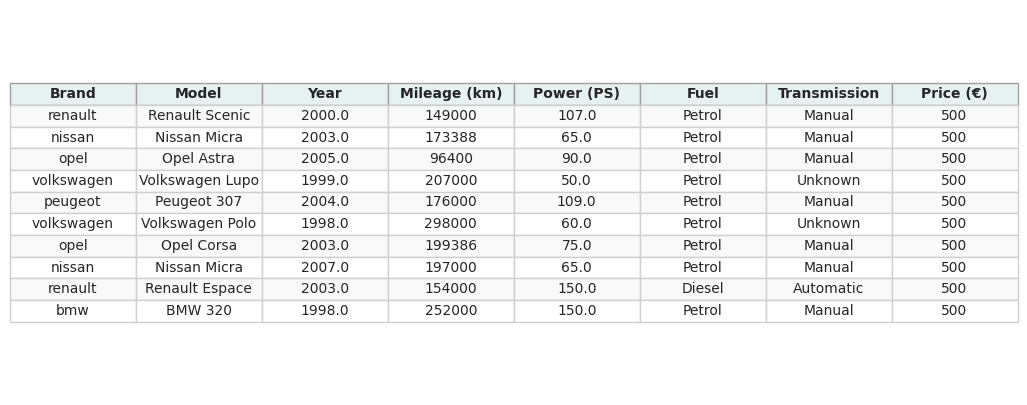

Saved: /content/figures/top10_cheapest.png


In [91]:
# ===========================================
# Top 10 Cheapest Listings
# ===========================================

cols = ["brand","model","year","mileage_in_km","power_ps","fuel_type","transmission_type","price_in_euro"]
cheapest = (df[cols]
            .sort_values("price_in_euro", ascending=True)
            .head(10)
            .copy())

cheapest_fmt = cheapest.rename(columns={
    "brand":"Brand",
    "model":"Model",
    "year":"Year",
    "mileage_in_km":"Mileage (km)",
    "power_ps":"Power (PS)",
    "fuel_type":"Fuel",
    "transmission_type":"Transmission",
    "price_in_euro":"Price (€)"
})

# make price and mileage neat
cheapest_fmt["Price (€)"] = cheapest_fmt["Price (€)"].round(0).astype(int)
cheapest_fmt["Mileage (km)"] = cheapest_fmt["Mileage (km)"].round(0).astype(int)

# === Plot as a nice table image ===
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13, 5))
ax.axis("off")

rows = len(cheapest_fmt)
row_colors = ["#F9F9F9" if i % 2 == 0 else "white" for i in range(rows)]

tbl = ax.table(cellText=cheapest_fmt.values,
               colLabels=cheapest_fmt.columns,
               cellLoc="center", colLoc="center",
               loc="center")

# header styling
for j in range(len(cheapest_fmt.columns)):
    tbl[0, j].set_facecolor("#E6F2F2")
    tbl[0, j].set_text_props(weight="bold")
    tbl[0, j].set_edgecolor("#A0A0A0")

# body styling
for i in range(rows):
    for j in range(len(cheapest_fmt.columns)):
        cell = tbl[i+1, j]
        cell.set_facecolor(row_colors[i])
        cell.set_edgecolor("#D0D0D0")

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

out = FIGDIR / "top10_cheapest.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out)


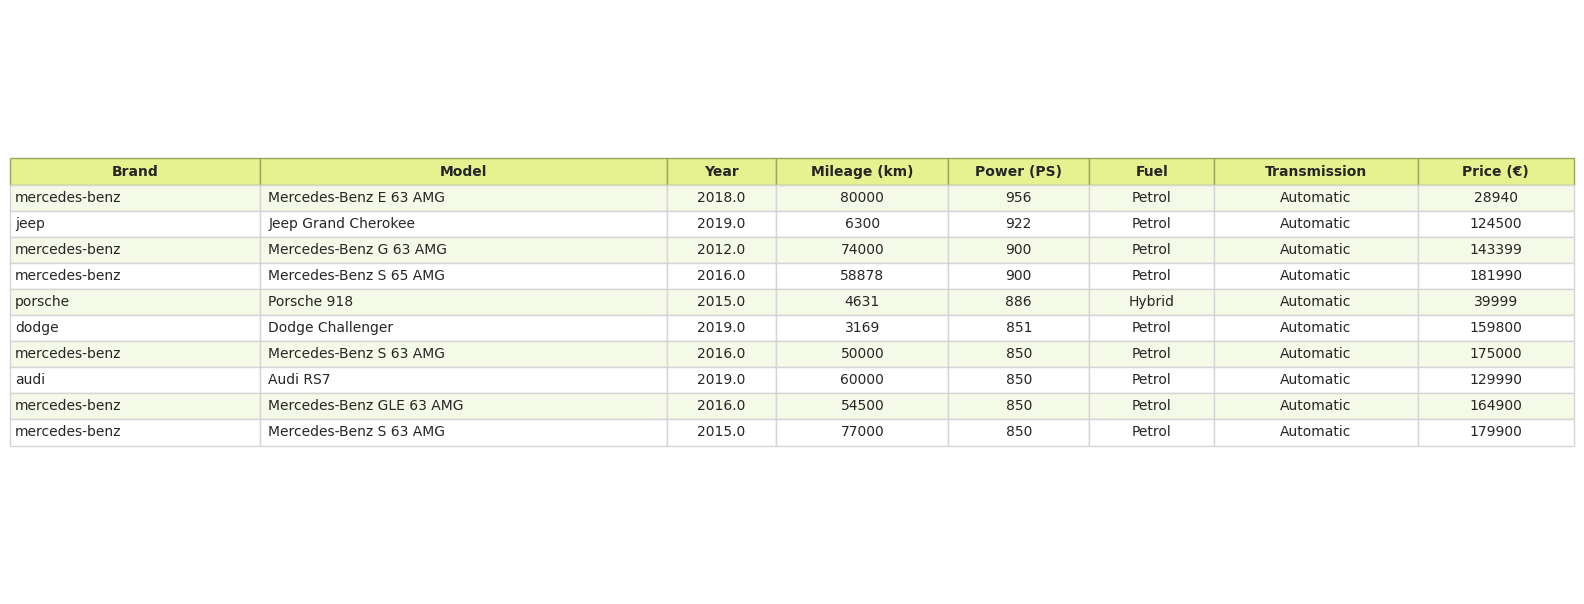

Saved: /content/figures/top10_powerful_pretty.png


In [98]:
# ===========================================
# Top 10 Most Powerful Listings
# ===========================================
import matplotlib.pyplot as plt
import textwrap # Import textwrap for shortening model names

# Get top 10 by horsepower
top_powerful = df.sort_values("power_ps", ascending=False).head(10).copy()

# Define columns to display
cols = ["brand", "model", "year", "mileage_in_km", "power_ps",
        "fuel_type", "transmission_type", "price_in_euro"]

# Select and rename columns for display
top_powerful_fmt = top_powerful[cols].rename(columns={
    "brand": "Brand",
    "model": "Model",
    "year": "Year",
    "mileage_in_km": "Mileage (km)",
    "power_ps": "Power (PS)",
    "fuel_type": "Fuel",
    "transmission_type": "Transmission",
    "price_in_euro": "Price (€)",
})

# numeric formatting
top_powerful_fmt["Price (€)"] = top_powerful_fmt["Price (€)"].round(0).astype(int)
top_powerful_fmt["Mileage (km)"] = top_powerful_fmt["Mileage (km)"].round(0).astype(int)
top_powerful_fmt["Power (PS)"] = top_powerful_fmt["Power (PS)"].round(0).astype(int) # Format Power (PS)

# shorten long model names for better fit (adjust width as needed)
def short(s, width=26):
    """Shorten string with ellipsis if longer than width."""
    s = str(s)
    if len(s) <= width:
        return s
    return textwrap.shorten(s, width=width, placeholder="…")

top_powerful_fmt["Model"] = top_powerful_fmt["Model"].map(lambda x: short(x, 28))


# ---- draw table ----
fig, ax = plt.subplots(figsize=(16, 6.2))  # Wider canvas
ax.axis("off")

# zebra striping
rows = len(top_powerful_fmt)
row_colors = ["#F5F9E7" if i % 2 == 0 else "white" for i in range(rows)]

# set fixed column widths (sum ~ 1.0). Adjust as needed.
colWidths = [0.16, 0.26, 0.07, 0.11, 0.09, 0.08, 0.13, 0.10]


tbl = ax.table(
    cellText=top_powerful_fmt.values,
    colLabels=top_powerful_fmt.columns,
    cellLoc="center", colLoc="center",
    colWidths=colWidths,
    loc="center"
)

# header style
for j in range(len(top_powerful_fmt.columns)):
    h = tbl[0, j]
    h.set_facecolor("#E6F28F")
    h.set_text_props(weight="bold")
    h.set_edgecolor("#9AA45C")

# body cells: zebra + borders + left-align Brand and Model
for i in range(rows):
    for j in range(len(top_powerful_fmt.columns)):
        c = tbl[i+1, j]
        c.set_facecolor(row_colors[i])
        c.set_edgecolor("#D5D5D5")
        if j in (0, 1):  # left-align Brand & Model
            c.get_text().set_ha("left")
            c.PAD = 0.02  # a touch of left padding


tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.28)

# save
out = FIGDIR / "top10_powerful_pretty.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out)

In [ ]:
# ====================================
# 8. Predictive Modeling (Ridge Regression)
# ====================================

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV # Use RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np # Import numpy for logspace

features = ["power_ps","mileage_in_km","car_age","brand","fuel_type","transmission_type"]
target = "price_in_euro" # Define target
data = df.dropna(subset=features+[target]) # Use target variable

X, y = data[features], data[target]

pre = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), ["power_ps","mileage_in_km","car_age"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), ["brand","fuel_type","transmission_type"])
])

alphas = np.logspace(-1, 2, 10) # Define alphas for RidgeCV
model = Pipeline([("pre", pre), ("ridge", RidgeCV(alphas=alphas, store_cv_results=False))]) # Use store_cv_results

Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2,random_state=42)
model.fit(Xtr,ytr); preds = model.predict(Xte)

print("R²:", round(r2_score(yte,preds), 3))
print("MAE (€):", round(mean_absolute_error(yte,preds), 0))
print("Chosen alpha:", model.named_steps["ridge"].alpha_) # Print chosen alpha

R²: 0.721
MAE (€): 6289.0
Chosen alpha: 2.1544346900318834


In [ ]:
print("Correlation price↔HP:", round(df["price_in_euro"].corr(df["power_ps"]), 3))
print("Correlation price↔mileage:", round(df["price_in_euro"].corr(df["mileage_in_km"]), 3))

# 2017 fuel mix snapshot (only if fuel_year exists)
try:
    display(fuel_year.query("year == 2017").sort_values("share", ascending=False))
except Exception as e:
    print("Note: fuel_year not in scope yet or 2017 not present. This is optional.")


Correlation price↔HP: 0.704
Correlation price↔mileage: -0.427


,year,fuel_type,share
283,"2,017.00",Petrol,0.54
51,"2,017.00",Diesel,0.43
167,"2,017.00",Hybrid,0.02
109,"2,017.00",Electric,0.01
225,"2,017.00",LPG,0.00
22,"2,017.00",CNG,0.00
196,"2,017.00",Hydrogen,0.00
80,"2,017.00",Diesel Hybrid,0.00
254,"2,017.00",Other,0.00
312,"2,017.00",Unknown,0.00


In [ ]:
# ====================================
# 9. Save Outputs
# ====================================

df.to_csv("/content/germany_used_cars_clean.csv", index=False)
print("Saved cleaned data to /content/germany_used_cars_clean.csv")
print("Saved figures to", FIGDIR.resolve())


Saved cleaned data to /content/germany_used_cars_clean.csv
Saved figures to /content/figures


## 10. Conclusions
- Price strongly correlates with horsepower (r = 0.70).
- Mileage negatively impacts price (r = -0.43).
- In 2017, diesel peaked (43%) while petrol dipped (54%), showing a market anomaly.
- Automatics overtook manuals after 2018.
- Ridge regression baseline achieved R² = 0.72 and MAE ≈ €6,300, giving a solid predictive benchmark.
